In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Intro: Sparse recovery and ISTA

We'll start by shortly testing the Iterative Soft Thresholding Algorithm (ISTA) for sparse recovery. This algorithm aims to solve the Basis Pursuit Denoising problem:
$$
\min_z \frac{1}{2} \| y - Mz\|_2^2 + \lambda \|z\|_1
$$

One way (there are many) to see the ISTA algorithm is as an *alternate gradient descent* on each term of the cost function. The first term is quadratic and easy. However, the $\ell_1$ norm in the second term is convex but not differentiable! Hence we replace the gradient descent step on this term with a so-called *proximal operator*, defined for any convex function $f$ as:
$$
\text{prox}_f(x) = \min_z \frac12 \| x-z \|_2^2 + f(z)
$$

**Q**: when $f$ is indeed differentiable, to what corresponds the operation $z^{(t+1)} = \text{prox}_{\eta f}(z^{(t)})$ for a small $\eta>0$ ?

Combining the two descent steps, the ISTA algorithm reads:
\begin{align*}
\hat z^{(t+1)} &= z^{(t)} - \eta M^\top (Mz^{(t)} - y) \\
z^{(t+1)} &= \text{prox}_{\eta' \lambda \|\cdot\|_1} (\hat z^{(t+1)})
\end{align*}
for small $\eta, \eta'$ (note that $\eta'$ can be integrated in $\lambda$).

**Q**: show that $\text{prox}_{\lambda \|\cdot\|_1}(x)$ is the Soft-Thresholding operator
$$
ST_\lambda(x) = \begin{cases}
x + \lambda &\text{if $x \leq -\lambda$} \\
0 &\text{if $-\lambda \leq x \leq \lambda$} \\
x - \lambda &\text{if $x \geq \lambda$}
\end{cases}
$$
Implement it simply by remarking that $ST_\lambda(x) = \text{sign}(x)\max(|x|-\lambda, 0)$ and plot it.

**Exo**: implement the BPD sparse recovery problem with a sparse vector $x$, a Gaussian iid measurement matrix $M$, and noiseless or noisy measurements. Test different dimensions $n,m,s$ and regularization parameter $\lambda$. Use pyplot's stem function for better visualisation.

# Main: Continuous sparsity

In this practical session, we'll look at some continuous sparsity problem. Be aware that this is still a very much active area of research, the algorithms are imperfect and often need some tuning !

You need to install torch! See here: https://pytorch.org/get-started/locally/ (install CPU only on laptop)

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam

## Fourier measurements on an interval

We start with the framework from "Off-the-grid compressed sensing" by Tang and Recht. In this paper,
the observation model is:
    $$
    y= [\sum_{k=1}^s c_k e^{i w_k j}]_{j \in T}
    $$
for some indices $T \subset \{0,\ldots, n-1\}$ of size $m$ and unknown amplitudes $c_k \in \mathbb{R}$ and frequencies $w_k \in [1,0]$.
    
Equivalently,
    $$
    y = \int_0^1 \phi(w) d\mu(w)
    $$
for a sparse Radon measure
    $$
    \mu = \sum_{k=1}^s c_k \delta_{w_k}
    $$
and a measuring function $\phi(w) = [e^{i w j}]_{j \in T}$.

We give some utilities to implement the observation model. Here, instead of manipulating complex numbers (not easy in torch), we prefer to separate real and imaginary part. The stored $y$ will therefore be in $\mathbb{R}^{2m}$ instead of $\mathbb{C}^m$.

In [28]:
def mat(w, T):
    """
        given positions, return a 2ind * s matrix containing the phi(w_k) as columns.
        The 2 factor is due to real vs complex.
    """
    return torch.cat((
            torch.cos(T[:,None] * w[None, :]),
            torch.sin(T[:,None] * w[None, :])))

def obs_model(w, c, T):
    """
        given positions and amplitudes, return the observed signal
    """
    return (mat(w, T) @ c.view(-1,1)).view(-1)

**Exo**: Given $n=400$ and $m=|T|=100$ indices selected randomly, generate the observed signal for $s=3$, choosing $c_k$ and $w_k$ as you please. Take $c_k$ sufficiently large (SNR). Plot the real part of $y$. Plot the full signal if we observed the full $T=\{0, \ldots, n-1\}$.

### Solving on a grid

We will first start by solving this problem on a grid. Given a frequency $f$, we consider frequency bins:
$$
F = \{1/f, 2/f, \ldots, 1\}
$$
With this model, we have approximately:
$$
y \approx M x
$$
with an approximately sparse $x \in \mathbb{R}^{|F|}$ containing the $c_k$ at indices $p_k \approx f w_k$, and $M$ containing the $\phi(1/f), \ldots \phi(1)$ as columns.

**Q**: Take $f=100$ and create the matrix $M$. Using the previous section, apply the ISTA algorithm to recover a sparse $x$. Compare the recovered positions within $F$ and the true ones $w_k$. (be careful that here we work with torch tensors, while the previous section worked with numpy. Use the utility .numpy() to convert a tensor)

**Q**: What do you observe? How thin must the grid be? What can you conclude on the coherence of the observation matrix?

### Simple improvement by non-convex optimization

A simple way to improve these results is to select a few Diracs on the grid among the ISTA solution, and use to initialize an optimization problem. The non-convex formulation reads:
$$
\min_{w,c} \|y - \sum_{k=1}^s c_k \phi(w_k)\|_2^2
$$

We will perform this optimization with Pytorch, using the Adam optimizer (a gradient descent with momentum). We give the optimization function below.

**Q**: comment the code

In [39]:
def optimize_positions(y, T, init_w, init_c, n_iter=2000, lr=.001):
    w = torch.tensor(init_w, requires_grad=True, dtype=torch.float)
    c = torch.tensor(init_c, requires_grad=True, dtype=torch.float)
    optimizer = Adam([w,c], lr=lr)
    iterates = []
    for _ in range(n_iter):
        loss = torch.nn.MSELoss()(y, obs_model(w, c, T))
        iterates.append(loss.item()) # store loss for debugging
        optimizer.zero_grad() # reinitialize gradients
        loss.backward() # backpropagation
        optimizer.step() # perform one step of gradient descent
        with torch.no_grad():
            w.clamp_(0,1) # help optimization by clamping positions between 0 and 1
    return w.detach(), c.detach(), iterates

**Q**: try to play with the parameters of the problem. Is non-convex optimization easy? Try to initialize the optimization with more Diracs extracted from the ISTA solution.

## Sketched learning

In sketched learning, the "integral" is taken as an empirical average over some observed data points. The "inverse" problem is then to recover the distribution $P$ of the data. Given $z_1, \ldots, z_N$ identically and independently distributed according to $P$, the law of large numbers give
$$
y = \frac{1}{N} \sum_{i=1}^n \psi(z_i) \approx \int \psi(z) dP(z)
$$

If we assume that $P = \sum_{k=1}^s c_k Q_{\theta_k}$ is a mixture model of template distributions $Q_\theta$ parameterized by $\theta$, then we find again
$$
y \approx \int \phi(\theta) d\mu(\theta) = \sum_{k=1}^s c_k \phi(\theta_k)
$$
with $\mu = \sum_{k=1}^s c_k \delta_{\theta_k}$ a sparse distribution, and $\phi(\theta) = \int \psi(z) dQ_\theta(z)$ the expectation of $\psi$ wrt $Q_\theta$. That's the previous problem. The big difference is that $\theta$ can be very high-dimensional!

### Gaussian Mixture Model

A simple example of this is Gaussian Mixture Model (GMM). Here
$$
Q_\theta = \mathcal{N}(\theta, Id)
$$
is a Gaussian distribution with identity covariance for simplicity. If we consider again
$$
\psi(z) = [e^{i w^\top z}]_{w \in T}
$$
for some set of (random, multi-dimensional) frequencies $T$, then $\phi$ is the characteristic function of $Q_\theta$:
$$
\phi(\theta) = [e^{i w^\top \theta} e^{-\|w\|_2^2 /2}]_{w \in T}
$$
We give the code to generate the $z_i$, an appropriate $T$, and the signal $y$ below.

(-5.9453733086586, 3.733752262592316, -4.936926078796387, 4.937854957580567)

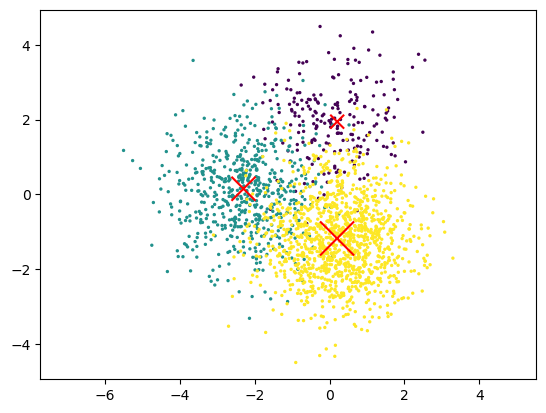

In [69]:
from sklearn.mixture import GaussianMixture
d = 2 # dimension
s = 3 # sparsity
true_thetas = 2*torch.randn(s, d)
true_c = torch.tensor([.1, .3, .6]) # must sum to 1 !

# sample data
N = 2000
gmm = GaussianMixture(n_components=3, covariance_type='spherical')
gmm.weights_ = true_c.numpy()
gmm.means_ = true_thetas.numpy()
gmm.covariances_ = np.ones(s)
data = gmm.sample(N)
labels = data[1]
Z = torch.tensor(data[0], dtype=torch.float)

# plot data
plt.figure()
plt.scatter(Z.numpy()[:,0], Z.numpy()[:,1], c=labels, s=2)
plt.scatter(true_thetas[:,0], true_thetas[:,1], marker='x', s=1000*true_c, c='r')
plt.axis('equal')

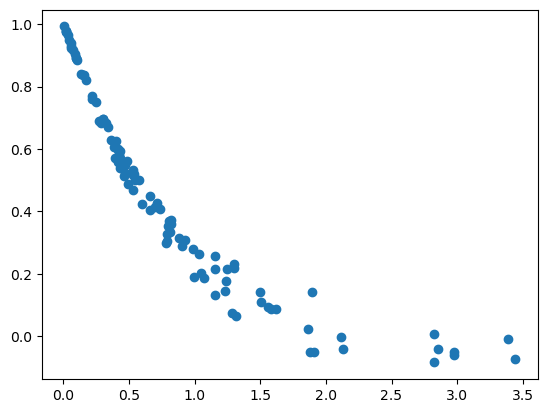

In [77]:
# random frequencies
m = 100
T = torch.randn(m,d)/np.sqrt(d) # variance 1/d for good scaling

y = torch.cat((
            torch.cos(T @ Z.T),
            torch.sin(T @ Z.T))).mean(axis=1)
# Display by increasing norm of freq
T_amp = (T**2).sum(axis=1)
plt.figure()
plt.scatter(T_amp, y[:m])

**Exo**: adapt the *mat* and *obs_model* functions to the new $\phi$. Compute the "true" value of $y^* = \int \phi(\theta) d\mu(\theta)$. Plot both $y$ and $y^*$ and compare.

### Greedy approach

In high dimension, it is "impossible" to perform the grid approach from earlier. Indeed, for a fixed precision, the size of the grid must be exponential with the dimension!

One possibility is to take inspiration from greedy approaches and add the components one by one, for instance by maximizing their correlation with the residual signal, and alternate this with the global non-convex optimization step from earlier. This has been formulated several times in the literature, inspired by MP-type algorithm (eg [here](https://arxiv.org/abs/1606.02838)) or by Frank-Wolfe iterative algorithm for convex minimization (eg [here](https://arxiv.org/abs/1811.06416))

In details, the algorithm reads
- 1. Initialize the support $S$ to $\emptyset$ and residual to $r = y$
- 2. Solve
$$
\hat \theta = \max_\theta \langle r , \phi(\theta)/\|\phi(\theta)\|_2 \rangle
$$
and add $\hat \theta$ to the support: $S \leftarrow S \cup \{\hat \theta\}$
- 3. Denote the current support $S = \{\hat \theta_1, \ldots, \hat \theta_{|S|}\}$ and initialize the Least Square amplitudes
$$
\hat c = \arg\min_{c} \|y - \sum_{k=1}^{|S|} c_k \phi(\hat \theta_k) \|_2^2
$$
- 4. Solve the non-convex optimization problem
$$
S, c = \arg\min_{S,c} \|y - \sum_{k=1}^{|S|} c_k \phi(\theta_k) \|_2^2
$$
initialized with $\hat S, \hat c$.
- 5. Update the residual $r = y - \sum_{k=1}^{|S|} c_k \phi(\theta_k)$
- 6. reiterate from 2.

**Exo**: Implement the optimization from step 2 using Pytorch. Test it on a simple instance with $s=1$. Compare the recovered $\theta$ with the average of the $z_i$

**Exo**: Implement the rest of the algorithm, adapting the non-convex optimization procedure from earlier and using torch.linalg.lstsq for Least Squares. Test it. Plot the data at each step of the algorithm